# FosCounter threshold adjusting trial

We recommend opening a small subset of images from the dataset and running this notebook to adjust the thresholding values

In [19]:
# import modules
import skimage as sk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import pandas as pd
import math
from scipy import ndimage as ndi
from scipy import stats
import imageio
import nd2
from processingFunctions import *
import warnings
warnings.filterwarnings('ignore')

In [20]:
#path to folder with the images
path="/Users/romina/Downloads/trial_images_PV_mcherry_CellCounter"
#retrieve all files from dataset folder
all_files=[]
for filename in os.listdir(path):
    if filename.endswith(".tif"):
        all_files.append(filename)
    if filename.endswith(".nd2"):
        all_files.append(filename)
print(all_files)

['vTRAP_rem memory_4-5m_R006.tif', 'vTRAP_rem memory_4-5m_R007.tif', 'vTRAP_rem memory_4-5m_D_1.tif', 'vTRAP_rem memory_4-5m_R005.tif', 'vTRAP_rem memory_4-5m_R004.tif', 'vTRAP_rem memory_4-5m_R001.tif', 'vTRAP_rem memory_4-5m_I.tif', 'vTRAP_rem memory_4-5m_R003.tif', 'vTRAP_rem memory_4-5m_R002.tif', 'vTRAP_rem memory_4-5m_A_1001.tif', 'vTRAP_rem memory_4-5m_A_1003.tif', 'vTRAP_rem memory_4-5m_E_1.tif', 'vTRAP_rem memory_4-5m_A_1002.tif', 'vTRAP_rem memory_4-5m_A_1005.tif', 'vTRAP_rem memory_4-5m_E_.tif', 'vTRAP_rem memory_4-5m_A_1004.tif', 'vTRAP_rem memory_4-5m_D_1003.tif', 'vTRAP_rem memory_4-5m_I001.tif', 'vTRAP_rem memory_4-5m_D_1002.tif', 'vTRAP_rem memory_4-5m_I003.tif', 'vTRAP_rem memory_4-5m_I002.tif', 'vTRAP_rem memory_4-5m_D_1001.tif', 'vTRAP_rem memory_4-5m_I005.tif', 'vTRAP_rem memory_4-5m_I004.tif', 'vTRAP_rem memory_4-5m_R.tif', 'vTRAP_rem memory_4-5m_E_001.tif', 'vTRAP_rem memory_4-5m_E_003.tif', 'vTRAP_rem memory_4-5m_E_002.tif', 'vTRAP_rem memory_4-5m_R008.tif', 'vTR

# Choose the parameters for the image
We recommend keeping the general parameters as they are (in exception of the channel which will depend on your dataset)

In [41]:
# General parameters
channelFos=0 #channel where Fos staining is
channelMC=2
axis_limit = 60
dist_thresh=25
axis_min=14
circ=0.98
axis_ratio= 0.4

# Fos parameters 
fos_thresh={
    "is_intensity_low":0, #use 0 if you have images with a high background, change to 1 if your images have low intensity and you wish to enhance contrast 
    "extra_bright_thresh": 99,
    "top_thresh":55, #this is gonna be the threshold for images with higher background, adjust it based on your settings
    "mid_thresh":99,#this is gonna be the threshold for images with medium background, adjust it based on your settings
    "low_thresh":20, #this is gonna be the threshold for images with lower background, adjust it based on your settings
    "high_int_thresh":80,
    "low_int_thresh":30
}

mc_thresh={
    "is_intensity_low":0, #use 0 if you have images with a high background, change to 1 if your images have low intensity and you wish to enhance contrast 
    "extra_bright_thresh": 99,
    "top_thresh":55, #this is gonna be the threshold for images with higher background, adjust it based on your settings
    "mid_thresh":99,#this is gonna be the threshold for images with medium background, adjust it based on your settings
    "low_thresh":20, #this is gonna be the threshold for images with lower background, adjust it based on your settings
    "high_int_thresh":80,
    "low_int_thresh":30
}

First run the intensitySaver function to obtain the classification parameters based on the intensity of the images to differentially apply the chose threshold values

In [44]:
fos_ints= intensitySaver(path, all_files, channelFos, fos_thresh.get("is_intensity_low")).getIntensityValues()
print (fos_ints)

mc_ints= intensitySaver(path, all_files, channelMC, mc_thresh.get("is_intensity_low")).getIntensityValues()
print(mc_ints)

{'low_int': 0.005193683064806737, 'high_int': 0.04077352191299214, 'int_cutoff_up': 1.1117817199423028, 'int_cutoff': 0.9291028117146298, 'int_cutoff_down': 0.49826556213280093}


In [32]:
#select one image to visualize if the thresholding is correct
test_image= "vTRAP_rem memory_4-5m_E_003.tif" #name of image file
data= path + "/"+ test_image #open an image here to examinate (note that you're gonna have to open a few to see how your images vary from each other)
fos_t, stacks=getImg(channelFos, data)
print(stacks) #will print the number of planes of the z-stack

10


## visualize how your images look after being thresholded with the previous parameters
visually inspect the chosen image and how it is being thresholded, and then adjust your thresholding values accordingly 

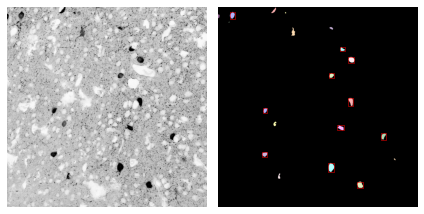

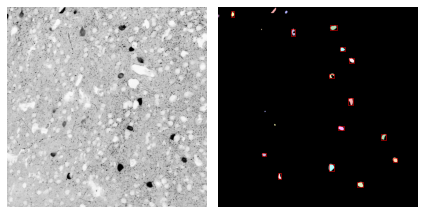

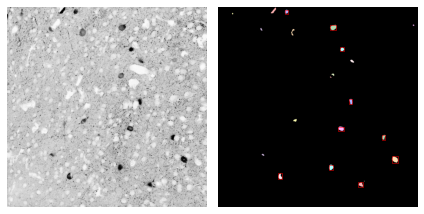

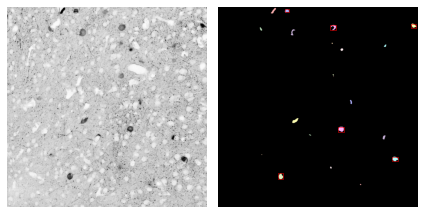

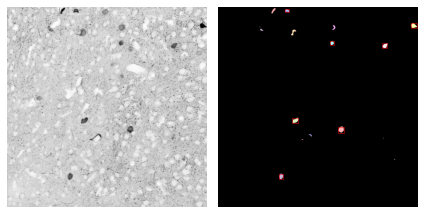

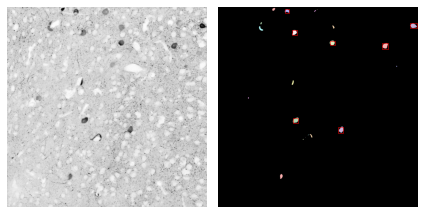

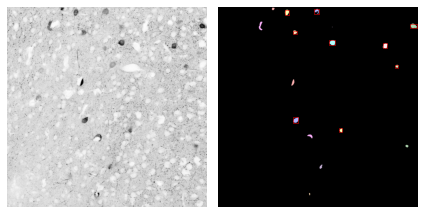

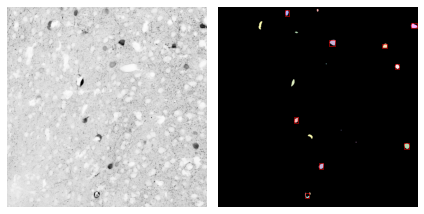

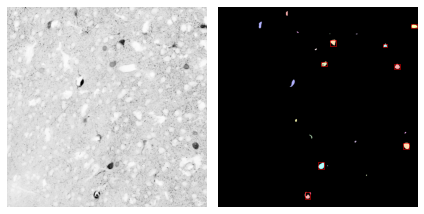

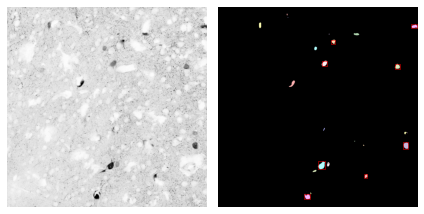

In [42]:
for i in range(stacks):
    fos_cc=fos_t[i]
    filt= getThresh(fos_cc).threshFos(fos_thresh, fos_ints)
    show_labels(filt, fos_cc, circ, axis_min, axis_limit, axis_ratio)

Print the counts of Fos+ cells

In [14]:
blobs_fos= getCoords(fos_t, stacks, circ, axis_ratio, axis_min, axis_limit).coordsFos(fos_thresh, fos_ints)
overlap=getOverlap(stacks, dist_thresh).overlap_coords(blobs_fos)
print(len(blobs_fos)-len(overlap))

24


Run the following cell to get the values of each plane to assess where to adjust values, the cell returns a dataframe with the classification values and the thresholding value to be applied

In [43]:
intInfo= pd.DataFrame(columns=["stack","classifier value", "25 p", "99 p", "threshold applied"])
for i in range(stacks):
    denoise=sk.restoration.denoise_wavelet(fos_t[i])
    blurred = sk.filters.gaussian(denoise, sigma=2.0)
    if fos_thresh.get("is_intensity_low") ==0:
        prepro=blurred
    else:
        prepro= sk.exposure.equalize_adapthist(blurred, kernel_size=127,clip_limit=0.01,  nbins=256)
    thresh=sk.filters.threshold_otsu(prepro)
    if np.percentile(prepro, 25)<= fos_ints.get("low_int"): 
        cat= "high_int_thresh"
    elif np.percentile(prepro,99)>= fos_ints.get("high_int"):
        cat= "low_int_thresh"
    else:
        if thresh/np.median(prepro)>=fos_ints.get("int_cutoff_up"):
            cat= "extra bright thresh"
        else:
            if thresh/np.median(prepro)<=fos_ints.get("int_cutoff"): 
                if thresh/np.median(prepro)<=fos_ints.get("int_cutoff_down"): 
                    cat= "low_thresh"
                else:
                    cat= "top thresh"
            else:
                cat= "mid thresh"
    val_list= [i, thresh/np.median(prepro),np.percentile(prepro, 25), np.percentile(prepro, 99), cat]
    c_series = pd.Series(val_list, index = intInfo.columns)
    intInfo = intInfo.append(c_series, ignore_index=True)
print(intInfo)


  stack  classifier value      25 p      99 p threshold applied
0     0          1.071224  0.013174  0.038469   high_int_thresh
1     1          1.148586  0.012810  0.035195   high_int_thresh
2     2          1.160090  0.012185  0.031707   high_int_thresh
3     3          1.111425  0.011351  0.028130   high_int_thresh
4     4          1.100262  0.010551  0.025506   high_int_thresh
5     5          1.106312  0.009786  0.024189   high_int_thresh
6     6          1.129092  0.009091  0.023130   high_int_thresh
7     7          1.143222  0.008450  0.022387   high_int_thresh
8     8          1.149563  0.007780  0.021615   high_int_thresh
9     9          1.169064  0.006967  0.020257   high_int_thresh


### once you have repetead the previous steps for a few images and decided on the final thresholding values,  copy them on the main file and run the script to obtain the Fos+ counts for the entire dataset